In [25]:
from matplotlib import pyplot as plt
import numpy as np
import torch as tr
from torch import nn
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
import csv
import draw_rna.draw as draw
from draw_rna.draw_utils import seq2col
import os 
import csv

In [26]:
def file_opener(file_name):
    data_set=[]
    with open(file_name, newline = '') as data:                                                                                         
        data_reader = csv.reader(data, delimiter='\t')
        for dat in data_reader:
            data_set.append(dat)
    return data_set
data_set=file_opener('data\sce_genes_folded.tab')

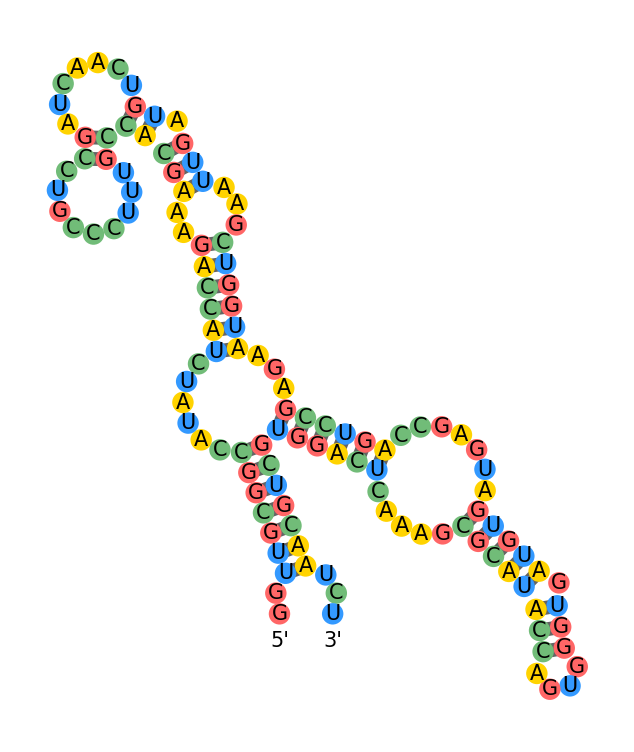

In [27]:
seq = data_set[7][1]
ref = data_set[7][2]
draw.draw_rna(data_set[12][1], data_set[12][2], seq2col(seq))

# UTILS

In [28]:
def seq_to_pair(seq):
    seq_np=list(seq)
    seq_open=[]
    pairs=[]
    for it,char in enumerate(seq_np):
        if (char=='('):
            seq_open.append(it+1)
        if (char==')'):
            pairs.append([seq_open[-1],it+1])
            seq_open=seq_open[:-1]
    pairs=pairs[::-1]
    # pairs=', '.join(str(e) for e in pairs)
    # pairs='['+pairs+']'
    return pairs


def replace_E(seq):
    str=list(seq)
    for it in range(len(str)):
        print(str[it])
        if(str[it]=='('):
            break    
        else:
            str[it]='-'
    print('SALIO')
    for it in range(len(str)-1,0,-1):
        if(str[it]==')'):
            break   
        else:
            str[it]='-'
    return str
    
    
def dot_to_motif(seq, struct):
    """Get motifs from dot-bracket notation structure. Requieres bpRNA.pl script"""

    with open('tmp.dbn', 'w') as fout:
        fout.write('>id\n')
        fout.write(f'{seq}\n')
        fout.write(f'{struct}\n')
        
    os.system('perl extras/bpRNA.pl tmp.dbn')
    with open('tmp.st') as fin:
        k = 0
        for line in fin:
            if line[0] == '#':
                continue
            if k == 2:
                motif = line.strip()
                break
            else:
                k += 1
    os.remove('tmp.dbn')
    os.remove('tmp.st')
    return motif

def seq_len(seq):
   lenght=len(list(seq))
   return lenght

def make_data_set(data_set):
    data=[['id','sequence','structure','base_pairs','len']]
    for i in data_set[:]:
        if seq_len(i[1]) < 130:
            data.append([i[0],i[1],i[2],seq_to_pair(i[2]),seq_len(i[1])])
      

        # data=data+i[0]+',SOLUTION NMR,'+i[1]+','+i[2]+','+'"'+pair+'"'+','+str(lenght)+'\n'
    writer=pd.DataFrame(data)
    writer.to_csv('test01.csv',sep=',',header=False,index=False)
    return data

def valid_mask(seq):
    """Create a NxN mask with valid canonic pairings."""
    valid_pairs = [{"G", "C"}, {"A", "U"}, {"G", "U"}]
    mask = tr.zeros((len(seq), len(seq)), dtype=tr.float32)
    for i in range(len(seq)):
        for j in range(len(seq)):
            if i != j:
                if {seq[i], seq[j]} in valid_pairs:
                    mask[i, j] = 1
                    mask[j, i] = 1
    return mask



((((((.......)))))),SSSSSSHHHHHHHSSSSSS,"[[1, 19], [2, 18], [3, 17], [4, 16], [5, 15], [6, 14]]",RNA,1997-08-14,,19

In [29]:
data=make_data_set(data_set)

In [30]:
import json
%matplotlib widget
data_test=pd.read_csv('urs_pdb_unique.csv')
lala=([json.loads(data_test.base_pairs.iloc[i]) for i in range(len(data_test))])


# Data_set

In [31]:
import torch as tr
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import json
from torch.nn.functional import cross_entropy

In [32]:

class OneHot():
    def __init__(self):
        self.pad_token = "-"
        self.vocabulary = ['A', 'U', 'G', 'C'] 
        self.emb_size = 4
        
    def seq2onehot(self, seq):
        emb = tr.zeros((self.emb_size, len(seq)), dtype=tr.float)
        for k, nt in enumerate(seq):
            # print(f'letra = {nt} indice = {k}')
            if nt == self.pad_token:
                continue
            if nt in self.vocabulary:
                emb[self.vocabulary.index(nt), k] = 1
            else:
                emb[:, k] = 1/self.emb_size
            # print(f'embedding = {emb}')
        return emb     

In [33]:
class Data_fold(Dataset):

    def __init__(self,dataset_path, min_len=0, max_len=200,padding=True,random_pad=False):
        dat=pd.read_csv(dataset_path,index_col=None)
        dat = dat[(dat.len > min_len) & (dat.len < max_len)]
        self.lenght=dat.len
        self.max_len=max_len
        self.id=dat.id
        self.seq=dat.sequence
        self.struct=dat.structure
        self.pair=[json.loads(dat.base_pairs.iloc[i]) for i in range(len(dat))]
        self.n_samples=dat.shape[0]
        self.padding = padding
        self.pad_token = '-'
        self.random_pad = random_pad
        self.embedding = OneHot()

    def __getitem__(self,index):
        len_seq = len(self.seq.iloc[index])
        connections = tr.tensor(self.pair[index]) -1
        sequence,Mc = self.pad_sequence(self.seq.iloc[index],connections)
        seq_emb=self.embedding.seq2onehot(sequence)
        mask = valid_mask(sequence)
        return seq_emb,Mc,len_seq,mask
    def __len__(self): 
        return self.n_samples

        
    def pad_sequence(self, sequence, connections):
        """Pad sequence and create connection matrix to max length"""
        left_pad, right_pad = 0, 0 
        if self.padding:
            left_pad = 0
            right_pad = self.max_len - len(sequence)
            if self.random_pad:
                left_pad = np.random.randint(right_pad)
                right_pad -= left_pad


        sequence = self.pad_token*left_pad + sequence + self.pad_token*right_pad
        # Conection matrix: -1 padding, 0 is not connected, 1 is connected
        Mc = -tr.ones((len(sequence), len(sequence)), dtype=tr.float32)      
        if right_pad > 0:
            Mc[left_pad:-right_pad, left_pad:-right_pad] = 0
        else:
            Mc[left_pad:, left_pad:] = 0

        if len(connections)>0:
            # for i in range(len(connections)):
            #     Mc[connections[][0] + left_pad, connections[i][1] + left_pad] = 1
            Mc[connections[:,0] + left_pad, connections[:,1] + left_pad] = 1
            Mc[connections[:,1] + left_pad, connections[:,0] + left_pad] = 1
        else:
            print(f"Warning: sequence {sequence} do not have any connections")
        return sequence, Mc.long()
    

Text(0.5, 1.0, 'Máscara de conexiones válidas (G-C, A-U, G-U)')

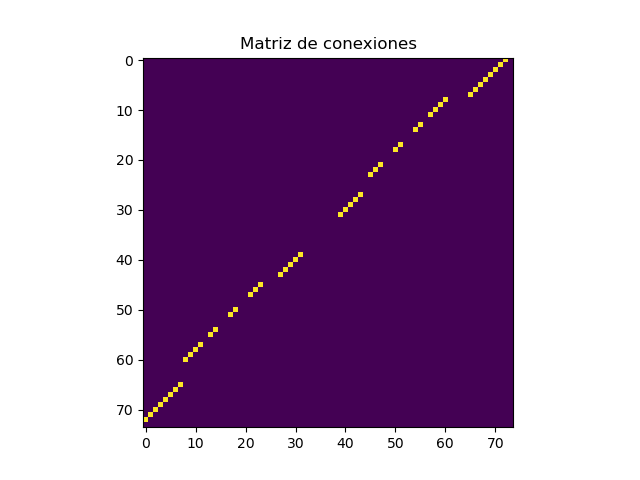

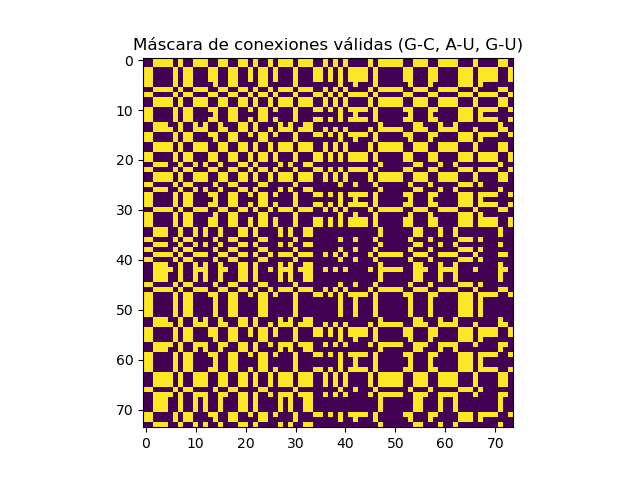

In [34]:
from matplotlib import pyplot as plt
%matplotlib widget
dataset=Data_fold('test01.csv')
sequence=dataset.seq
L = len(sequence)
seq_emb,mc,long,mask=dataset.__getitem__(158)
plt.imshow(mc[:long, :long])
plt.title("Matriz de conexiones")
plt.figure()
plt.imshow(mask[:long, :long])
plt.title("Máscara de conexiones válidas (G-C, A-U, G-U)")

# metrics

In [35]:
from sklearn.metrics import f1_score
#se suele usar f1 score para todo lo que sean matrices?????????!
def get_f1(ref_batch,predict_batch,L,th=0.5):
    f1 = []
    for ref,predict,l in zip(ref_batch,predict_batch,L):
        ind = tr.where(ref!=-1)
        ref = ref[ind].view(l, l)
        predict = predict[ind].view(l, l)

        #esto si no lo entiendo
        predict = tr.sigmoid(predict) > th

        #parte para tener la matriz triangular superior
        ind = tr.triu_indices(ref.shape[0], ref.shape[1], offset=1)
        ref = ref[ind[0], ind[1]].numpy().ravel()
        predict = predict[ind[0], ind[1]].numpy().ravel()
        f1.append(f1_score(ref, predict, zero_division=1))
    return tr.tensor(f1).mean()
    

c:\Users\ignac\anaconda3\envs\env1\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Model


In [36]:
class ignacioFold(nn.Module):
    def __init__(self, embedding_dim=4, device="cpu", negative_weight=.1, lr=1e-3, 
    logger=None, pred_l1=.01, use_scheduler=False, **kwargs):
        super().__init__()
        self.device=device
        #por que espesificamente el adam
        #para luego escalar de 0 a 1 el crossentropy
        self.class_weight = tr.tensor([negative_weight, 1.]).float().to(device)
        self.build_graph(embedding_dim, **kwargs)
        self.optim =  tr.optim.Adam(self.parameters(), lr=lr)

        self.to(device)


    
    def build_graph (self,emb_dim,kernel=9,filters=50,rank=32):
        pad = (kernel-1)//2
        dilation = 4
        self.cnn = nn.Sequential(nn.Conv1d(in_channels=emb_dim, out_channels=filters, 
                                        kernel_size=kernel, padding = pad, stride=1),
                                nn.ReLU(),
                                nn.BatchNorm1d(filters),
                                nn.Conv1d(in_channels=filters, out_channels=filters, 
                                        kernel_size=kernel, dilation = dilation,
                                        padding=dilation*pad, stride=1),
                                nn.ReLU(),
                                nn.BatchNorm1d(filters),
                                nn.Conv1d(in_channels=filters, out_channels=filters, 
                                        kernel_size=kernel, dilation = dilation,
                                        padding=dilation*pad, stride=1),
                                nn.ReLU(),
                                nn.BatchNorm1d(filters),
                                nn.Conv1d(in_channels=filters, out_channels=filters//2, 
                                        kernel_size=kernel, padding = pad, stride=1),
                                nn.Sigmoid(),)  
        self.convsal1 = nn.Conv1d(in_channels=filters//2, out_channels=rank, kernel_size=kernel, 
                                  padding=pad, stride=1)
        self.convsal2 = nn.Conv1d(in_channels=filters//2,  out_channels=rank, kernel_size=kernel,
                                  padding = pad, stride=1)

    def forward (self,x):
        n = x.shape[2]
        y = self.cnn(x)
        ya = self.convsal1(y)
        ya = tr.transpose(ya, -1, -2)

        yb = self.convsal2(y)
        
        y = ya @ yb
        yt =  tr.transpose(y, -1, -2)
        
        y = (y+yt)/2
    
        #por que pone vectores adentro de otro vectores
        y = y.view(-1, n, n)
        return y
#loss and optim
    def loss_func(self,yt,y):

        #devuelta lo mismo
        y = y.view(y.shape[0], -1)
        yt = yt.view(yt.shape[0], -1)

        #no es la diferencia?
        pred_l1_loss =  tr.mean(tr.abs(yt[y!=-1])) * 0.01 


        #por que no usar devuelta view
        yt = yt.unsqueeze(1)
        #hizo algo el codigo anterior desp de esto? tipo no se deshizo?
        yt = tr.cat((-yt, yt), dim=1) 
        error = cross_entropy(yt, y, ignore_index=-1, weight=self.class_weight)
        loss=error +pred_l1_loss
        return loss
    
    def tr(self,data_loader):
        self.train()
        avg_loss=0
        avg_f1 = 0
        train_step = 0
        for batch in data_loader:
            x = batch[0].to(self.device)
            y = batch[1].to(self.device)
            self.optim.zero_grad()  
            y_tr = self.forward(x)
            loss = self.loss_func(y_tr,y)
            f1 = get_f1(y.cpu(), y_tr.detach().cpu(), batch[2])
            avg_f1 += f1
            avg_loss += loss
            loss.backward() 
            self.optim.step()
            train_step+=1

        avg_f1 /= len(data_loader)
        avg_loss /= len(data_loader)
        return avg_loss,avg_f1
    def tst(self,data_loader):
        self.eval() 
        avg_loss=0
        avg_f1=0
        test_step = 0
        #desactivamos el gradiente por que no hacemos backward()
        with tr.no_grad():       
            for batch in data_loader:
                x = batch[0].to(self.device)
                y = batch[1].to(self.device)
                #por que aca y no desp
                y_tst = self.forward(x)
                # y_tst=tr.tensor([[x], *batch[2:]])
                loss = self.loss_func(y_tst,y)
                #.detach()?????????
                f1 = get_f1(y.cpu(), y_tst.detach().cpu(), batch[2])
                avg_loss += loss
                avg_f1 += f1
                test_step+=1
            avg_loss /= len(data_loader)
            avg_f1 /= len(data_loader)
            
            return avg_loss,avg_f1


# main

hacer los 3 data sets y luego levantar, no hacer un data set y luego separarlo en train, val y test
///
usar de indice el indice de las sequencias!!!!!

agregar reglas de coneccion

In [41]:
model = ignacioFold(kernel=11)

In [42]:
import torch as tr
from torch.utils.data import DataLoader, random_split

out_path = f"results/"
batch_size = 16
DEVICE = "cuda" 
model = ignacioFold(kernel=11, device=DEVICE) 
dataset=Data_fold('urs_pdb_unique.csv')

#las mismas particiones para comparar desp con el mismo dataset

n_train = int(0.8 * len(dataset))
n_test = int(0.1 * len(dataset))
n_val = len(dataset) - n_train - n_test


#por que le ponen una seed????
train_data, val_data, test_data = random_split(dataset, [n_train, n_val, n_test], generator=tr.Generator().manual_seed(42))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("train batches", len(train_loader))
print("val batches", len(val_loader))
print("test batches", len(test_loader))
best_f1, patience_counter = 0, 0
for epoch in range(500):
    train_loss,train_f1 = model.tr(train_loader)
    print(f'train loop epoch {epoch}')
    val_loss,val_f1 = model.tst(val_loader)
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_epoch = epoch
        tr.save(model.state_dict(), f"{out_path}model_200len.pmt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter>50:
            break
    print(f"epoch {epoch}: train loss {train_loss:.2f} val loss {val_loss:.2f} train f1 {train_f1:.2f} val f1 {val_f1:.2f}")
print("Start test")
model.load_state_dict(tr.load(f"{out_path}model_200len.pmt"))
test_loss, test_f1 = model.tst(test_loader)
print(f"best epoch {best_epoch} best_valf1 {best_f1:.3f} test_loss {test_loss:.3f} test_f1 {test_f1:.3f}")


train batches 40
val batches 5
test batches 5
train loop epoch 0
epoch 0: train loss 0.31 val loss 0.30 train f1 0.01 val f1 0.04
train loop epoch 1
epoch 1: train loss 0.24 val loss 0.24 train f1 0.10 val f1 0.16
train loop epoch 2
epoch 2: train loss 0.22 val loss 0.24 train f1 0.17 val f1 0.20
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\ignac\anaconda3\envs\env1\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ignac\AppData\Local\Temp\ipykernel_18676\883840484.py", line 28, in <module>
    train_loss,train_f1 = model.tr(train_loader)
  File "C:\Users\ignac\AppData\Local\Temp\ipykernel_18676\420036785.py", line 81, in tr
    for batch in data_loader:
  File "c:\Users\ignac\anaconda3\envs\env1\lib\site-packages\torch\utils\data\dataloader.py", line 628, in __next__
    data = self._next_data()
  File "c:\Users\ignac\anaconda3\envs\env1\lib\site-packages\torch\utils\data\dataloader.py", line 671, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "c:\Users\ignac\anaconda3\envs\env1\lib\site-packages\torch\utils\data\_utils\fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "c:\Users

In [39]:
import torch as tr
from torch.utils.data import DataLoader, random_split

out_path = f"results/"
batch_size = 16
DEVICE = "cuda" 
model = ignacioFold(kernel=11, device=DEVICE) 
model.load_state_dict(tr.load(f"{out_path}model_200len.pmt"))
dataset=Data_fold('test01.csv',max_len=800)

#las mismas particiones para comparar desp con el mismo dataset

n_train = int(0.8 * len(dataset))
n_test = int(0.1 * len(dataset))
n_val = len(dataset) - n_train - n_test


#por que le ponen una seed????
train_data, val_data, test_data = random_split(dataset, [n_train, n_val, n_test], generator=tr.Generator().manual_seed(42))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("train batches", len(train_loader))
print("val batches", len(val_loader))
print("test batches", len(test_loader))
best_f1, patience_counter = 0, 0
for epoch in range(250):
    train_loss,train_f1 = model.tr(train_loader)
    print(f'train loop epoch {epoch}')
    val_loss,val_f1 = model.tst(val_loader)
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_epoch = epoch
        tr.save(model.state_dict(), f"{out_path}model_800len_translr.pmt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter>50:
            break
    print(f"epoch {epoch}: train loss {train_loss:.2f} val loss {val_loss:.2f} train f1 {train_f1:.2f} val f1 {val_f1:.2f}")
print("Start test")
model.load_state_dict(tr.load(f"{out_path}model_800len_translr.pmt"))
test_loss, test_f1 = model.tst(test_loader)
print(f"best epoch {best_epoch} best_valf1 {best_f1:.3f} test_loss {test_loss:.3f} test_f1 {test_f1:.3f}")

train batches 45
val batches 6
test batches 6
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\ignac\anaconda3\envs\env1\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ignac\AppData\Local\Temp\ipykernel_18676\508260182.py", line 29, in <module>
    train_loss,train_f1 = model.tr(train_loader)
  File "C:\Users\ignac\AppData\Local\Temp\ipykernel_18676\420036785.py", line 81, in tr
    for batch in data_loader:
  File "c:\Users\ignac\anaconda3\envs\env1\lib\site-packages\torch\utils\data\dataloader.py", line 628, in __next__
    data = self._next_data()
  File "c:\Users\ignac\anaconda3\envs\env1\lib\site-packages\torch\utils\data\dataloader.py", line 671, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "c:\Users\ignac\anaconda3\envs\env1\lib\site-packages\torch\utils\data\_utils\fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "c:\Users